In [75]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from src.shap_show import shap_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from src.preprocess_data import preprocess_data, clean_text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from src.FastTextVectorizer import FastTextVectorizer
from src.utilits import applay_thresholds, metrics_model, get_top_tox, explain_text, explain_text_fasttext
from src.find_optimal_threshold import find_optimal_threshold



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('data\\train.csv')
TARGET = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
RANDOM_STATE = 42
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<BarContainer object of 6 artists>

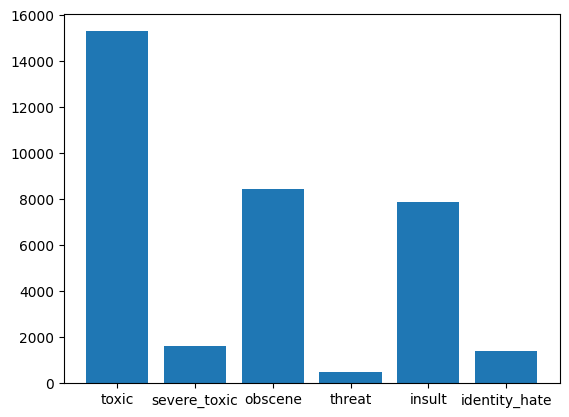

In [3]:
plt.bar(TARGET, df[[x for x in TARGET]].sum())

In [4]:
non_toxic_count = df[df[TARGET].sum(axis=1) == 0].shape[0]
toxic_count = df[df[TARGET].sum(axis=1) > 0].shape[0]
total_count = df.shape[0]
toxic_percent = toxic_count / total_count * 100

print(f'About the dataset: ',
    f'total samples: {total_count} ',
    f'Non-toxic samples: {non_toxic_count} ',
    f'Toxic samples: {toxic_count} '
    f'({toxic_percent:.2f}%) toxic samples',
    sep='\n')

About the dataset: 
total samples: 159571 
Non-toxic samples: 143346 
Toxic samples: 16225 (10.17%) toxic samples


Baseline:

TF-IDF + Logistic Regression / Linear SVM

In [5]:
train_df, val_df  = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [34]:
model_tf_idf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), preprocessor=clean_text)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])
model_tf_idf.fit(train_df['comment_text'], train_df[TARGET])
prob_tf_idf = model_tf_idf.predict_proba(val_df['comment_text'])

In [38]:
print("--------------------------------")
print("Metrics with default threshold:")
metrics_model(val_df[TARGET], prob_tf_idf)
best_thresholds, best_scores = find_optimal_threshold(val_df[TARGET].values, prob_tf_idf)
print("Metrics with optimal thresholds:")
metrics_model(val_df[TARGET], prob_tf_idf, thresholds=best_thresholds)
print(f'Validation ROC-AUC Score: {roc_auc_score(val_df[TARGET], prob_tf_idf)}')


--------------------------------
Metrics with default threshold:
--------------------------------
F1 Score (macro): 0.4884
F1 Score (micro): 0.6696
Accuracy: 0.9183
Precision: 0.3324
Recall: 0.3775
--------------------------------
Metrics with optimal thresholds:
--------------------------------
F1 Score (macro): 0.5918
F1 Score (micro): 0.7144
Accuracy: 0.9094
Precision: 0.3888
Recall: 0.6129
--------------------------------
Validation ROC-AUC Score: 0.9710443590112909


In [44]:
print(model_tf_idf.predict(["FUCK"]), model_tf_idf.predict(["F1ACK"]), model_tf_idf.predict(["F U C K"]))

[[1 1 1 0 1 0]] [[0 0 0 0 0 0]] [[0 0 0 0 0 0]]


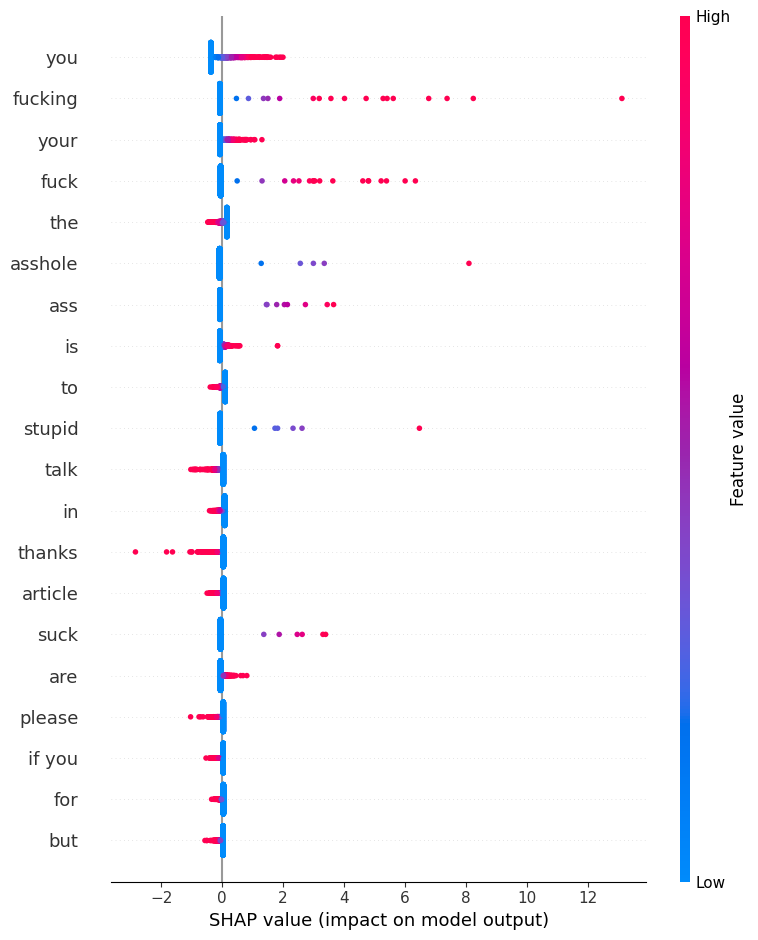

TOXIC WORDS:
['fuck' 'fucking' 'stupid' 'shit' 'idiot' 'ass' 'bullshit' 'asshole'
 'crap' 'suck' 'bitch' 'dick' 'sucks' 'penis' 'you' 'faggot' 'moron'
 'hell' 'pathetic' 'cunt']

NON-TOXIC WORDS:
['thank' 'thanks' 'thank you' 'talk' 'best' 'please' 'utc' 'welcome'
 'if you' 'help' 'may' 'see' 'wp' 'at' 'interested' 'could' 'sorry'
 'cheers' 'appreciate' 'article']


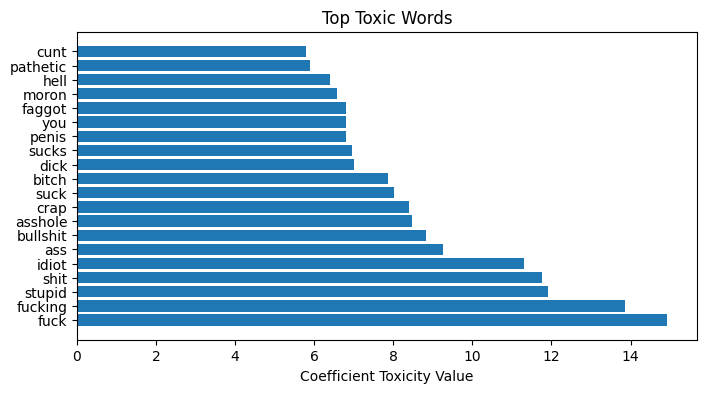

In [ ]:
shap_model(model_tf_idf.named_steps['clf'], model_tf_idf.named_steps['tfidf'], train_df)
get_top_tox(model_tf_idf.named_steps['tfidf'], model_tf_idf.named_steps['clf'])

FastText:
- Word embeddings + Linear classifier


In [63]:
FastText_pipeline = Pipeline([
    ('fasttext', FastTextVectorizer(vector_size=300, window=3, epochs=20, min_n=3, max_n=6)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])
FastText_pipeline.fit(train_df['comment_text'], train_df[TARGET])
FastText_val_probs = FastText_pipeline.predict_proba(val_df['comment_text'])

In [65]:
print("--------------------------------")
best_thresholds, best_scores = find_optimal_threshold(val_df[TARGET].values, FastText_val_probs)
print("Metrics with optimal thresholds:")
metrics_model(val_df[TARGET], FastText_val_probs, thresholds=best_thresholds)
print(f'Validation ROC-AUC Score: {roc_auc_score(val_df[TARGET], FastText_val_probs)}')

--------------------------------
Metrics with optimal thresholds:
--------------------------------
F1 Score (macro): 0.2561
F1 Score (micro): 0.3425
Accuracy: 0.8285
Precision: 0.1062
Recall: 0.3038
--------------------------------
Validation ROC-AUC Score: 0.8201237996079894
